# Detect Outliners

In [10]:
import pandas as pd
import sys
sys.path.append('../src')
import outliners
import numpy as np

## Import data

In [11]:
feature_data = pd.read_csv('../data/processed/features_simple_processed.csv')
original_cols = feature_data.columns
print(feature_data.info())
print(feature_data.describe())
feature_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status          1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status,other_debtors,residence_since,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


## Outliners Exploration

In [12]:
target_cols = feature_data.select_dtypes(include=['number']).columns
print(target_cols)
for col in target_cols:
    feature_data[str(col) + '_outliner'] = outliners.detect_outliers_iqr(feature_data[col])
feature_data.iloc[:, -len(target_cols):].sum()

Index(['duration', 'credit_amount', 'installment_rate', 'residence_since',
       'age', 'existing_credits', 'num_dependents'],
      dtype='object')


duration_outliner             70
credit_amount_outliner        72
installment_rate_outliner      0
residence_since_outliner       0
age_outliner                  23
existing_credits_outliner      6
num_dependents_outliner      155
dtype: int64

In [19]:
for col in target_cols:
    feature_data[str(col) + '_outliner'] = outliners.detect_outliers_zscore(feature_data[col])
feature_data.iloc[:, -len(target_cols):].mean()

duration_outliner            14
credit_amount_outliner       25
installment_rate_outliner     0
residence_since_outliner      0
age_outliner                  7
existing_credits_outliner     6
num_dependents_outliner       0
dtype: int64

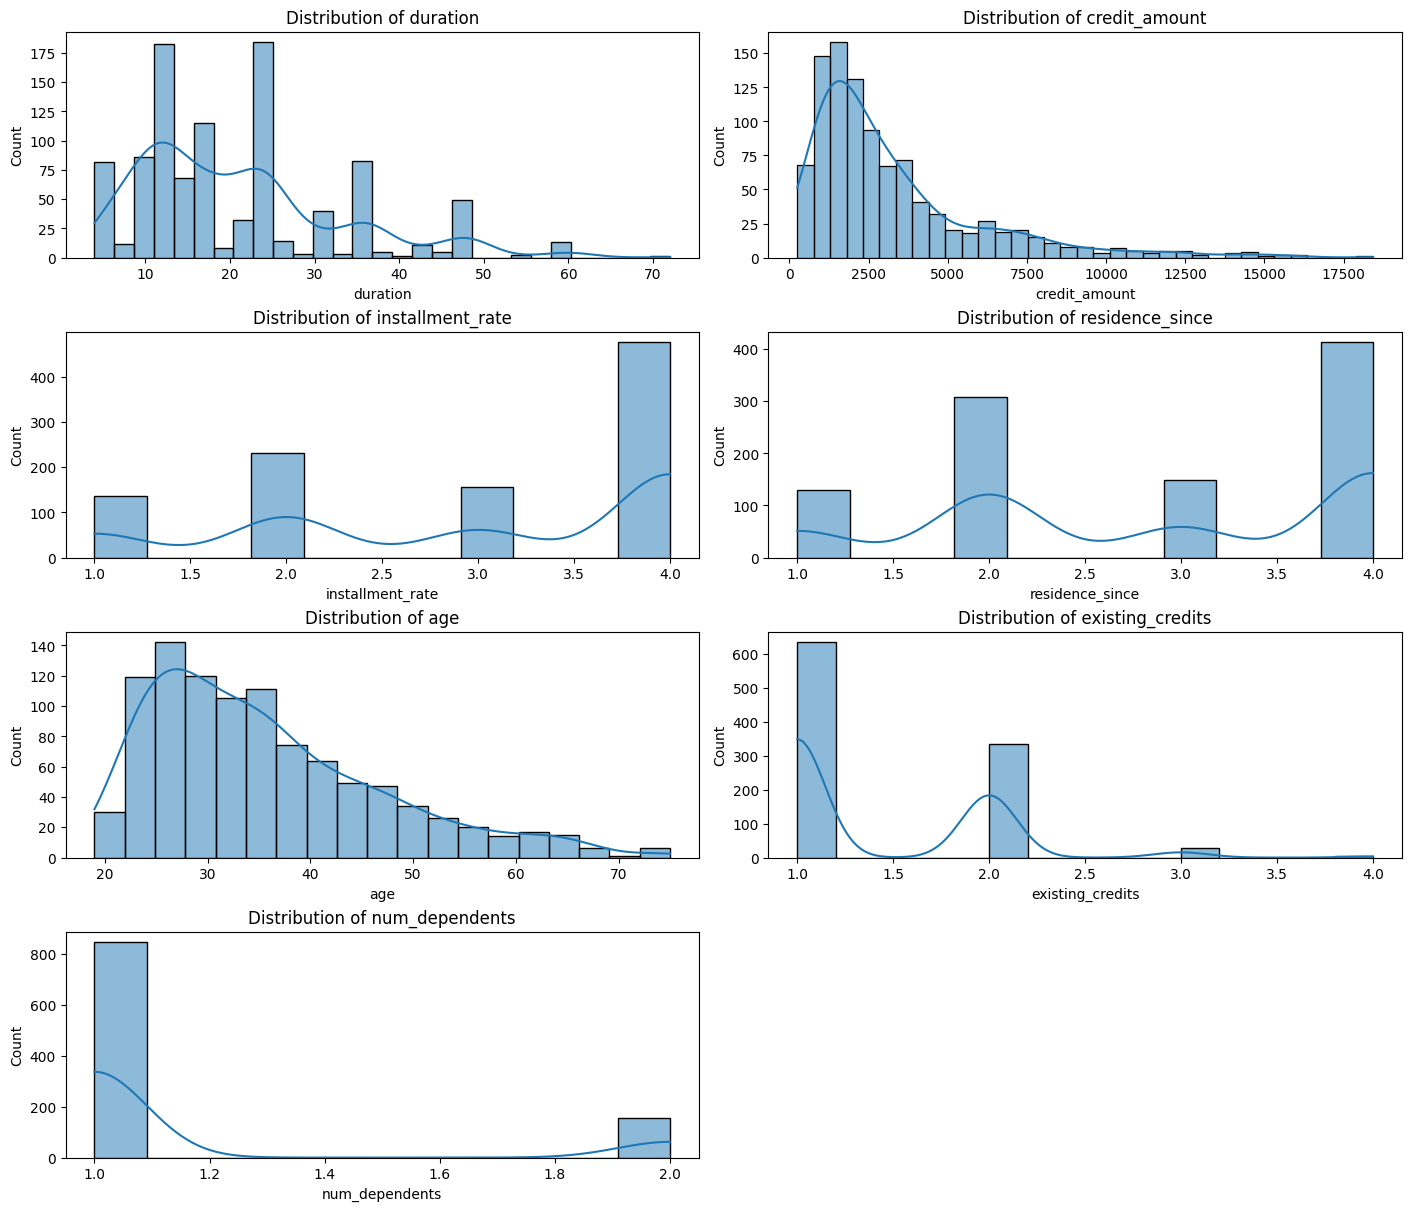

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=(len(target_cols) + 1) // 2, ncols=2, figsize=(14, 3 * ((len(target_cols) + 1) // 2)), constrained_layout=True)

axes = axes.flatten()

for ax, col in zip(axes, target_cols):
    sns.histplot(
        data=feature_data, 
        x=col, 
        kde=True, 
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f'Distribution of {col}')

# Hide any unused subplots
for i in range(len(target_cols), len(axes)):
    fig.delaxes(axes[i])

plt.show()

Some columns such as 'installment_rate', 'residence_since', 'existing_credits', and 'num_dependents' are discrete variables with very few unique values. 

Their discrete nature and limited value range cause them to be detected as outliers by the IQR method, which is not appropriate in this context.

Therefore, we will exclude these columns from the list of columns for outlier processing.

And due to the EDA and outliner detectors, we choose z-scores here for the following process.


# Winsorize Outliners

In [21]:
discrete_cols = ['installment_rate', 'residence_since', 'existing_credits', 'num_dependents']
outliner_cols = [col for col in target_cols if col not in discrete_cols]
print("Columns for outlier processing:", outliner_cols)

Columns for outlier processing: ['duration', 'credit_amount', 'age']


In [30]:
feature_data_w = feature_data.copy()
target_data = pd.read_csv('../data/processed/targets_simple_processed.csv')

for col in outliner_cols:
    feature_data_w[col] = outliners.winsorize_series(feature_data_w[col], lower=0.015, upper=0.985)
    m_all = outliners.fit_and_metrics(feature_data[[col]].to_numpy(), target_data['class'].to_numpy())
    m_win = outliners.fit_and_metrics(feature_data_w[[col]].to_numpy(), target_data['class'].to_numpy())
    print("="*10)
    print(f"Sensitivity Analysis for {col}:")
    sens_table = pd.DataFrame([m_all, m_win], index=['all', 'winsorized'])
    print(sens_table)

Sensitivity Analysis for duration:
               slope  intercept        r2       mae
all        -0.008172   0.870813  0.046193  0.400599
winsorized -0.008409   0.875083  0.046372  0.400524
Sensitivity Analysis for credit_amount:
               slope  intercept        r2       mae
all        -0.000025   0.782219  0.023944  0.409944
winsorized -0.000026   0.783146  0.022745  0.410447
Sensitivity Analysis for age:
               slope  intercept        r2       mae
all         0.003673   0.569444  0.008304  0.416512
winsorized  0.003742   0.567199  0.008331  0.416501


# Import Winsorized data

In [33]:
print(feature_data_w.describe())

          duration  credit_amount  installment_rate  residence_since  \
count  1000.000000    1000.000000       1000.000000      1000.000000   
mean     20.820000    3240.442175          2.973000         2.845000   
std      11.740589    2694.799046          1.118715         1.103718   
min       6.000000     453.910000          1.000000         1.000000   
25%      12.000000    1365.500000          2.000000         2.000000   
50%      18.000000    2319.500000          3.000000         3.000000   
75%      24.000000    3972.250000          4.000000         4.000000   
max      54.000000   12681.035000          4.000000         4.000000   

               age  existing_credits  num_dependents  
count  1000.000000       1000.000000     1000.000000  
mean     35.485000          1.407000        1.155000  
std      11.182255          0.577654        0.362086  
min      20.000000          1.000000        1.000000  
25%      27.000000          1.000000        1.000000  
50%      33.000000   

In [34]:
feature_data_w = feature_data_w[original_cols]
feature_data_w.to_csv('../data/processed/features_winsorized.csv', index=False)